In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import normalize 
from sklearn.metrics import silhouette_samples, silhouette_score


In [2]:
employee_data = pd.read_csv('HR_comma_sep.csv', sep=',')
# employeeData=train_data.copy(deep=True)
# ['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company','Work_accident','promotion_last_5year','departmennt','salary','left']

In [3]:
employee_data.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,departmennt,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1
5,0.41,0.50,2,153,3,0,0,sales,low,1
6,0.10,0.77,6,247,4,0,0,sales,low,1
7,0.92,0.85,5,259,5,0,0,sales,low,1
8,0.89,1.00,5,224,5,0,0,sales,low,1
9,0.42,0.53,2,142,3,0,0,sales,low,1


In [17]:
left_employees= employee_data[employee_data["left"]==1]
left_employees= left_employees.drop(["Work_accident","departmennt","salary","left","promotion_last_5years"], axis=1)
# left_employees
X=left_employees.to_numpy()
X=normalize(X) #normalize the data.

#Now using the Elbow Method to pick the optimal K
#Using silhouette scores
diff_k= [i for i in range(1,11)]
diff_k_results=[]
silouhette_scores=[]
for k in diff_k:
    kmeans=KMeans(n_clusters=k, n_init=15).fit(X)
    diff_k_results.append(kmeans.inertia_)
    if k==1:
        continue
    silouhette_scores.append(silhouette_score(X,kmeans.labels_))




***The Silouhette Score is generally regarded as a good metric for finding out the optimal number of clusters. Here we use it and plot the silouhette score from k=2 to k=10. The general rule of thumb is to pick the value of k where the average silouehette score value is maximized as it shows that the values are in the correct clusters and are far away from their second closest clusters***


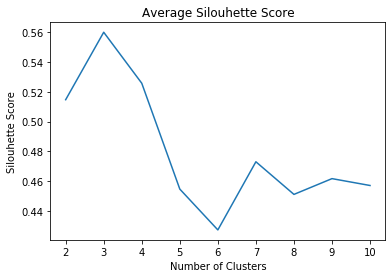

In [30]:
# print(silouhette_scores)
plt.plot(diff_k[1:], silouhette_scores)
plt.xticks(diff_k[1:])
plt.title("Average Silouhette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silouhette Score")
plt.show()


<h2>As we can see, k=3 is the optimal number of clusters so we will cluster accordingly.</h2>

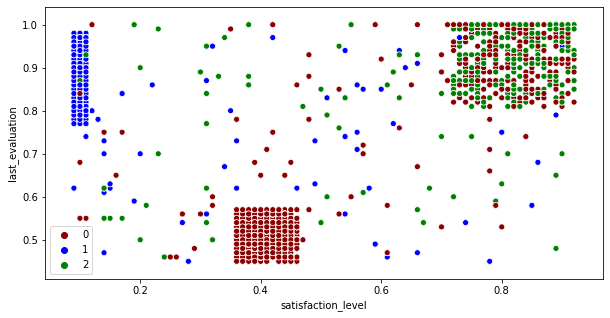

In [68]:
kmeans = KMeans(n_clusters = 3, n_init=15).fit(X)
labels=kmeans.labels_
left_employees['label']=kmeans.labels_
plt.figure(figsize=(10,5))
colors=["#8B0000", "#0000FF","#008000"]
palette=sns.color_palette(colors, n_colors=3)
sns.scatterplot("satisfaction_level","last_evaluation",hue=labels,data=left_employees, palette=palette)
plt.show()




- Cluster 1: Most of cluster 2 is placed in the middle, with moderate satisfaction levels and performance. These group of individuals could be classified as unmotivated. They might be underworked.
- Cluster 2: High performing individuals but with very low satisfaction levels. This gets explained in the plot below.  
- Cluster 3: These individuals have high performance and high satisfaction yet they still left the company. We will investigate on this further later.

Overall we see three nicely clustered groups. However, we also see cluster 1 and cluster 3 together where people from cluster 1 have high satisfaction levels and high performance. Why did they leave? We will investigate further below.


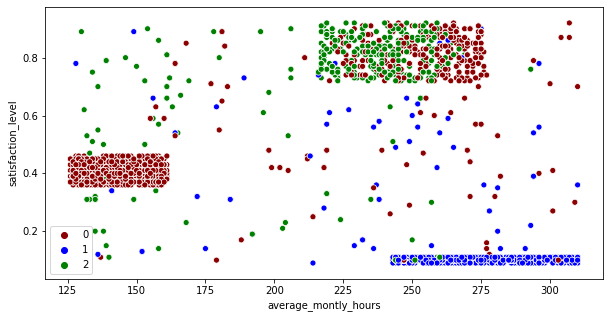

In [69]:
colors=["#8B0000", "#0000FF","#008000"] #Red, Blue, Green
palette=sns.color_palette(colors, n_colors=3)
plt.figure(figsize=(10,5))
sns.scatterplot("average_montly_hours","satisfaction_level",hue=labels,data=left_employees, palette=palette)
plt.show()



- Cluster 1: Moderate satisfaction levels with very low monthly hours. This confirms our assumption from above that these individuals may be unmotivated or simply have a lack of work which leads to them leaving the company. 
- Cluster 2: We saw these people were highly rated but had poor satisfaction levels and this plot shows why. They have the highest monthly working hours and were getting overworked which is why they left.
- Cluster 3: These people have moderate to high working hours but high satisfaction levels too. However, they also left. They had peculiar behavior in the previous plot too, we will look at this further. 

We also see some cluster 1 individuals grouped alongside cluster 3 with high satisfaction and work hours, we will look into that

In [51]:
left_employees.groupby("label").mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
label,,,,,
0,0.507305,0.616267,2.576687,174.016045,3.550260
1,0.138147,0.855246,6.091099,273.033508,3.941361
2,0.733763,0.888833,5.012072,223.756539,5.142857


From this we see that the employees that are left are clustered as follows:
<ol>
<li> Cluster 1: Moderate satisfaction level, moderate performance, and the least amount of workload. After spending an average of 3+ years in the company, it seems that lack of work led to them leaving seeking pastures anew. 
<li>Cluster 2: Highly rated by the company but having the least satisfaction level, these employees were overworked by the company which led to them leaving.
<li>Cluster 3: These employees are highly rated, and have a decent amount of workload and have spent over 5 years on average within the company. However, despite everything looking fine, they still left! We explore this with the help of other variables below
</ol>

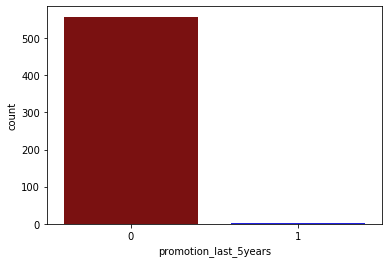

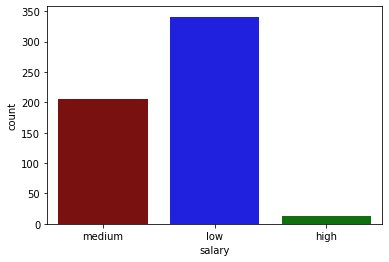

In [74]:
left_employees_original=employee_data[employee_data["left"]==1].copy()
left_employees_original['label']=labels
cluster2_left=left_employees_original[left_employees_original['label']==2]
sns.countplot('promotion_last_5years',data=cluster2_left)
plt.show()

sns.countplot('salary', data=cluster2_left)
plt.show()

Hardly ANYONE from cluster 3 got promoted despite their high work hours, performance, etc. This explains why they left.
Moreover, majority of the people in cluster 2 had a low salary. After spending an average of 5+ years in the company, it's reasonable to expect a promotion and a raise if you're also performing well.

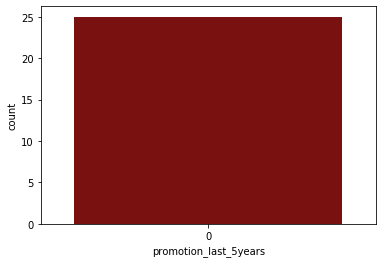

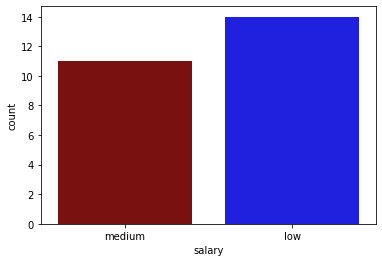

In [75]:
cluster1=left_employees_original[left_employees_original['label']==1]
cluster1_high_satisfaction= cluster1[cluster1["satisfaction_level"]>0.6]
sns.countplot("promotion_last_5years",data=cluster1_high_satisfaction)
plt.show()

sns.countplot("salary", data=cluster1_high_satisfaction)
plt.show()

In [76]:
cluster1_high_satisfaction.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left,label
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.00,25.0,25.0,25.0
mean,0.762400,0.741200,4.560000,228.760000,2.440000,0.04,0.0,1.0,1.0
std,0.092883,0.173741,1.260952,43.365962,0.711805,0.20,0.0,0.0,0.0
min,0.610000,0.450000,3.000000,128.000000,2.000000,0.00,0.0,1.0,1.0
25%,0.660000,0.580000,3.000000,216.000000,2.000000,0.00,0.0,1.0,1.0
50%,0.780000,0.750000,5.000000,227.000000,2.000000,0.00,0.0,1.0,1.0
75%,0.850000,0.900000,5.000000,263.000000,3.000000,0.00,0.0,1.0,1.0
max,0.900000,1.000000,7.000000,296.000000,4.000000,1.00,0.0,1.0,1.0


We separated the people in cluster 1 who were showing irregular patterns. These people had high satisfaction levels and were also getting a decent amount of work yet they still left the company. 
They spent an average of 2 and a half years with the company but weren't getting paid according to the work they were doing and nobody got promoted either. 

# Outlier Analysis

In our initial boxplots from deliverable 1, we saw a few outliers in the attribute "time_spend_company". All the other variables seemed to follow a distribution so let's focus on this one.

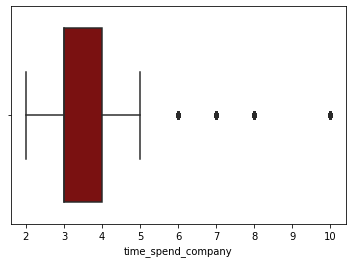

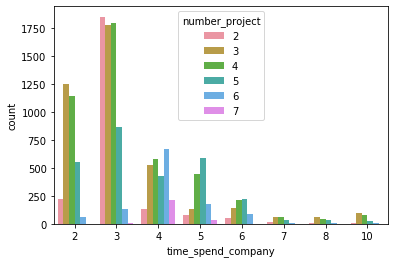

In [134]:
sns.boxplot("time_spend_company", data=employee_data)
plt.show()

# sns.scatterplot("time_spend_company","number_project", data=employee_data)
sns.countplot("time_spend_company", hue="number_project", data=employee_data)

The general relationship is that as you spend more years within the company, you are given more projects

In [194]:
from sklearn.preprocessing import MinMaxScaler
scaled_data=MinMaxScaler().fit_transform(employee_data[["time_spend_company", "number_project"]])
lof= LocalOutlierFactor(n_neighbors=20, contamination="auto")
outliers=lof.fit_predict(scaled_data)
num_outliers=len([outlier for outlier in outliers if outlier==-1])
print("Outliers",num_outliers)
employee_data_new=employee_data.copy()
employee_data_new['outliers']=outliers

employee_data_new.columns

Outliers 66


Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'departmennt', 'salary', 'left', 'outliers'],
      dtype='object')

In [167]:
def plot_outliers(X,Y,outliers, col_names):
    color_map={-1:"red", 1:"green"}
    plt.figure(figsize=(12,7))
    colors_arr=[color_map[x] for x in outliers]
    plt.scatter(X,Y, color=colors_arr, label="Red: Outlier")
    plt.legend(loc="best")
    leg = plt.gca().get_legend()
    leg.legendHandles[0].set_color('red')
    plt.xlabel(col_names[0])
    plt.ylabel(col_names[1])
    plt.show()


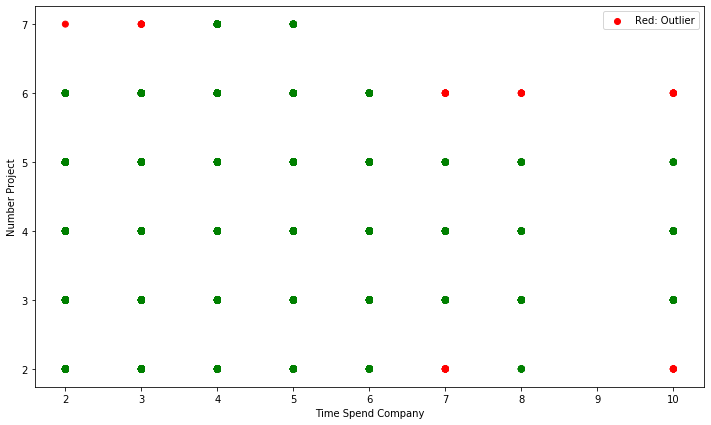

In [195]:
col_names=["Time Spend Company", "Number Project"]
plot_outliers(employee_data_new.iloc[:,4],employee_data_new.iloc[:,2], outliers, col_names )


We saw that the general trend was the more time you spend with the company, the more the company trusts you and gives you more projects. However, there are a few outliers here as we see people with over 7 years in the company getting the least number of projects and vice versa i.e. having spent only 2-3 years and getting 7 projects

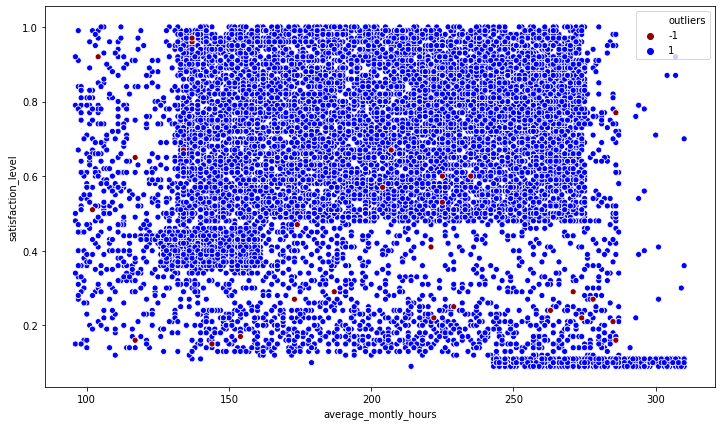

In [201]:
plt.figure(figsize=(12,7))
sns.scatterplot("average_montly_hours","satisfaction_level", hue="outliers",data=employee_data_new, palette=palette[0:2])
plt.show()


Outlier: -1 (red), inlier (1), blue

The general trend we saw with clustering is that the satisfaction level goes down with more workload (high average monthly hours). However, there are some outliers here too with people having low-moderate monthly hours and are also less satisfied. One possible explanation is that they lack motivation or are going through a stagnation phase.

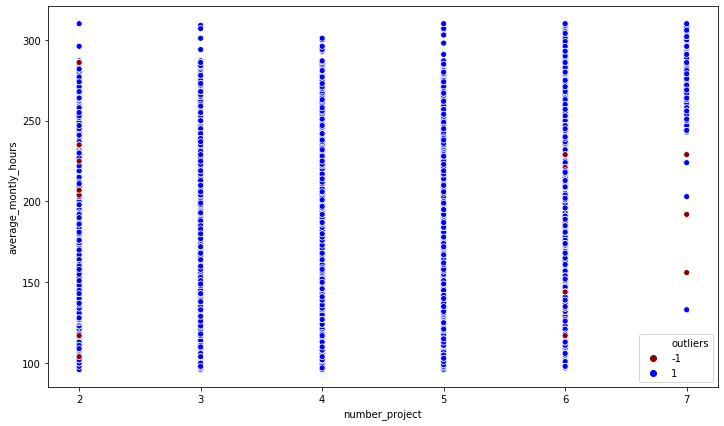

In [202]:
plt.figure(figsize=(12,7))
sns.scatterplot("number_project","average_montly_hours",hue="outliers",palette=palette[:2],data=employee_data_new)
plt.show()

Outlier: -1, red. Inlier: 1, blue

Typically, the more projects you have, the more the workload (monthly hours). However, there are some people with a high number of projects but not the monthly hours to show for it. Similarly, people with only 2 projects can be seen having higher hours. 

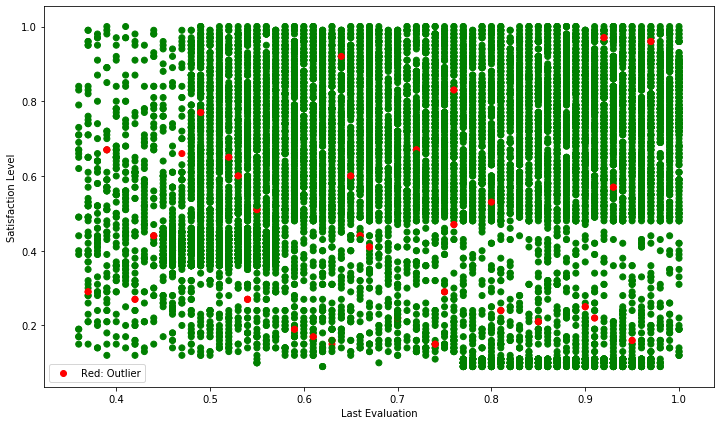

In [196]:
col_names=["Last Evaluation", "Satisfaction Level"]
plot_outliers(employee_data_new.iloc[:,1],employee_data_new.iloc[:,0], outliers, col_names)


Some outliers we see: There are some people with high performance have low satisfaction levels. Similarly, low performance, low satisfaction (unmotivated, low-performers), and some who are just in the middle

# Outliers for Employees that Left


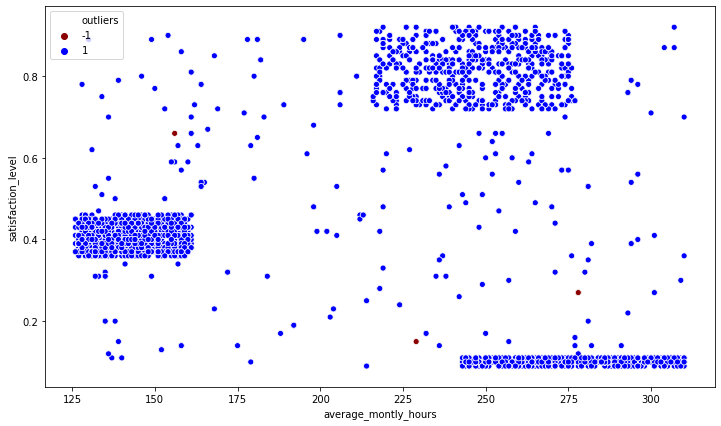

In [197]:
# plot_outliers(employee_data_new.iloc[:,6],employee_data_new.iloc[:,9], outliers, col_names)
plt.figure(figsize=(12,7))
left_outliers=employee_data_new[employee_data_new["left"]==1].copy()
sns.scatterplot("average_montly_hours","satisfaction_level", hue="outliers",data=left_outliers, palette=palette[0:2])
plt.show()


Outlier: -1, red, inlier: 1, blue

Previously, we saw that people with more workload tend to leave the company. That is mostly true but here we see that there are some who had less workload and even had a high satisfaction but they still left. 

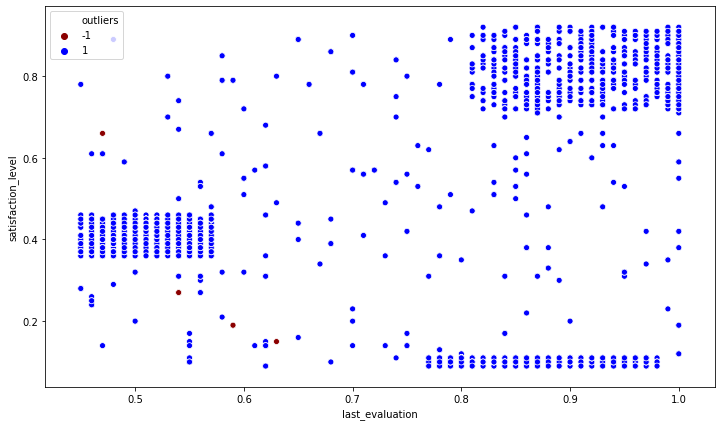

In [199]:
plt.figure(figsize=(12,7))
sns.scatterplot("last_evaluation","satisfaction_level",hue="outliers",palette=palette[:2],data=left_outliers)
plt.show()

Outlier: -1, red. Inlier: 1, blue.

Some outliers: People with low performance also had low satisfaction. Compared to the rest of the data, such data points are classified as outliers because in our previous analysis we've seen people either leave due to low satisfaction high performance or vice versa. The outlier is when both are bad.

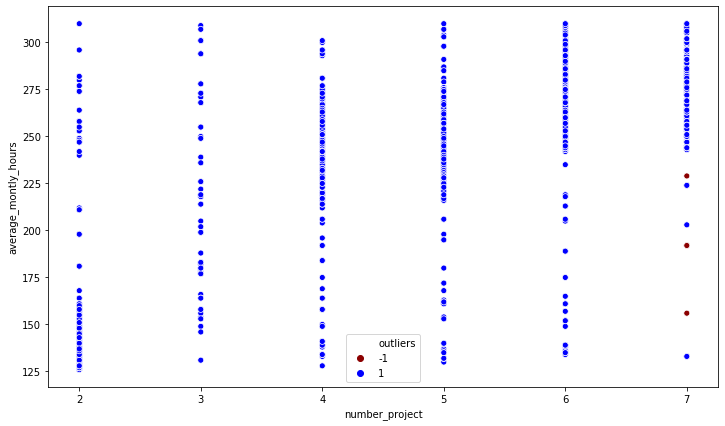

In [203]:
plt.figure(figsize=(12,7))
sns.scatterplot("number_project", "average_montly_hours",hue="outliers", palette=palette[:2],data=left_outliers)
plt.show()

Outlier: -1, red. Inlier: blue.

It's a similar trend to what we've seen before. People have a high number of projects but are not clocking in the required number of hours. These people also left the company, perhaps due to feeling overwhelmed, or feeling unmotivated due to the amount of work that they were given.